In [4]:
from oct_Utils import *
from tqdm.notebook import tqdm
from PIL import Image 
import numpy as np
import pandas as pd
from oct_Utils import *
from multiprocessing import Pool
import time



In [34]:
def show_volume(img_array):
    fig = plt.figure()
    #plt.subplot(1, 2, 1)
    #plt.imshow(img_array[0], cmap='gray')

    volume = np.stack(img_array, axis=0)
    volume = volume.mean(axis=1)
    #print(volume.shape)
    ax=plt.gca()
    im=ax.imshow(cv2.resize(volume, dsize=(256, 256), interpolation=cv2.INTER_LINEAR),cmap='gray')
    print(type(im))
    print(im.norm.vmin, im.norm.vmax)
    plt.axis('off')#添加了参数用来去除掉白边
    #plt.show()
    plt.savefig('/home/octusr3/project/oct_1124/temp.jpg',bbox_inches='tight',pad_inches=0.0)
    plt.show()
    plt.close(fig)

def calculate_vmin_vamx(tasks):
    max_num=[]
    min_num=[]
    for task in tasks:
        img_array = read_imgs_targz(task)
        volume = np.stack(img_array, axis=0)
        volume = volume.mean(axis=1)
        max_num.append(np.max(volume))
        min_num.append(np.min(volume))
    #return np.mean(np.array(max_num)),np.mean(np.array(min_num))
    return max_num,min_num

def cal_max_min(task):
    img_array = read_imgs_targz(task)
    volume = np.stack(img_array, axis=0)
    volume = volume.mean(axis=1)
    return np.max(volume),np.min(volume)

# def save_z_slice(img_array,save_path,vmin=60,vmax=90):
#     fig = plt.figure()
#     volume = np.stack(img_array, axis=0)
#     volume = volume.mean(axis=1)
#     ax=plt.gca()
#     im=ax.imshow(cv2.resize(volume, dsize=(256, 256), interpolation=cv2.INTER_LINEAR),vmin=vmin,vmax=vmax,cmap='gray')
#     plt.axis('off')#添加了参数用来去除掉白边
#     plt.savefig(save_path,bbox_inches='tight',pad_inches=0.0)
#     plt.close(fig)

def get_mean(res):
    min=[]
    max=[]
    for i in res:
        min.append(i[0])
        max.append(i[1])
    return np.mean(np.array(min)),np.mean(np.array(max))

# def cut_z_slice(tasks,output_path):
#     for task in tqdm(tasks):
#         img_array = read_imgs_targz(task)
#         save_z_slice(img_array,task)

def chunk(list, n):
    result = []
    for i in range(n):
        result.append(list[math.floor(i / n * len(list)):math.floor((i + 1) / n * len(list))])
    return result

def run_multi_process(item_list, n_proc, func, with_proc_num=False):
    tasks = chunk(item_list, n_proc)
    if with_proc_num:
        for i in range(len(tasks)):
            tasks[i] = (i, tasks[i])
    with multiprocessing.Pool(processes=n_proc) as pool:
        results = pool.map(func, tasks)
    return results


def extract_zslice_mp(tasks):
    input_root = Path('/home/octusr2/projects/data_fast/proceeded/volume_targz')
    #output_root = Path(f'/home/octusr2/projects/data_fast/proceeded/cp_projection/{size}')
    output_root = Path(f'/home/octusr3/project/data_fast/z_slice')
    info = pd.read_csv('/home/octusr2/projects/data_fast/proceeded/volume_info/volume_info.csv')
    info['oct_path'] = info['oct_path'].map(lambda x: str(Path(x).with_suffix('')))
    info = info.drop_duplicates(subset='oct_path')
    info = info.set_index('oct_path')
    
    errors = run_multi_process(tasks, 80, partial(extract_zslice, input_root=input_root, output_root=output_root, info=info), with_proc_num=True)
    #errors = reduce(lambda x, y: x + y, errors)
    #pkl_dump(errors, 'data/errors_cp.pkl')


def extract_zslice(tasks, input_root, output_root, info,vmin=60,vmax=90):
    info = info.copy()
    proc_num, tasks = tasks
    errors = []
    with Benchmark(f'Converting', print=proc_num == 0) as t:
        for i, task in enumerate(tasks):
            if i % (len(tasks) // 10 + 1) == 0:
                t.print_elapsed(f'{i}/{len(tasks)}, {i / len(tasks) * 100:.2f}%')
            task = Path(task).relative_to(input_root)
            info_key = str(task.with_suffix('').with_suffix(''))
            if info_key not in info.index:
                err = Exception('No oct info.')
                errors.append((task, err))
                # print(f'Error with file {str(task)}: {err}')
                continue
            volume_size = info.loc[info_key, 'oct_x']
            input_path = str(input_root / task)
            output_path = (output_root / task).with_suffix('.jpg')
            eye = ''
            if 'OD' in input_path:
                eye = 'OD'
            else:
                eye = 'OS'
            if eye == '':
                err = Exception('No eye infomation (OS/OD)')
                errors.append((task, err))
                # print(f'Error with file {str(task)}: {err}')
                continue
            try:
                imgs = read_imgs_targz(input_path)
                #cp = cut_cp_from_imgs(imgs, volume_size=volume_size, flip=eye=='OS', radius=1.4, threshold=100, size=(size, size))
                ensure_file(output_path)
                #fig = plt.figure()
                volume = np.stack(imgs, axis=0)
                volume = volume.mean(axis=1)
                ax=plt.gca()
                ax.imshow(cv2.resize(volume, dsize=(256, 256), interpolation=cv2.INTER_LINEAR),vmin=vmin,vmax=vmax,cmap='gray')
                plt.axis('off')#添加了参数用来去除掉白边
                plt.savefig(output_path,bbox_inches='tight',pad_inches=0.0)
                #plt.close(fig)
                plt.clf() 
                #Image.fromarray(cp).save(output_path)
            except Exception as err:
                errors.append((task, err))
                # print(f'Error with file {str(task)}: {err}')
    return errors

    

In [70]:
extract_zslice_mp(tvasks)

Converting: begin
Converting, 0/418, 0.00%: 0.00 seconds
Converting, 42/418, 10.05%: 95.24 seconds
Converting, 84/418, 20.10%: 359.76 seconds
Converting, 126/418, 30.14%: 725.44 seconds
Converting, 168/418, 40.19%: 1083.02 seconds
Converting, 210/418, 50.24%: 1426.74 seconds
Converting, 252/418, 60.29%: 1793.89 seconds
Converting, 294/418, 70.33%: 2080.04 seconds
Converting, 336/418, 80.38%: 2342.44 seconds
Converting, 378/418, 90.43%: 2604.44 seconds
Converting: 2743.85 seconds


In [2]:
input_root = Path('/home/octusr2/projects/data_fast/proceeded/volume_targz')
info = pd.read_csv('/home/octusr2/projects/data_fast/proceeded/volume_info/volume_info.csv')
output_path=Path('/home/octusr3/project/data_fast/z_slice')
def get_all_volumes(cache=True):
    if cache and os.path.isfile('/home/octusr2/projects/data_fast/filelists/all_volumes.json'):
        return json_load('/home/octusr2/projects/data_fast/filelists/all_volumes.json')
    tasks = []
    for dirpath, dirnames, filenames in os.walk('/home/octusr2/projects/data_fast/proceeded/volume_targz'):        
        for filename in filenames:
            if filename.endswith('.tgz'):
                tasks.append(f'{dirpath}/{filename}')
        print(len(tasks), end="\r", flush=True)
    #json_dump(tasks, '/home/octusr2/projects/data_fast/filelists/all_volumes.json')
    return tasks

tasks = get_all_volumes(cache=False)#获取了所有的路径

In [60]:
extract_zslice_mp(tasks)

Converting: begin
Converting, 0/418, 0.00%: 0.00 seconds


/home/octusr3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/octusr3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/octusr3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, 

Converting, 42/418, 10.05%: 183.08 seconds
Converting, 84/418, 20.10%: 379.40 seconds
Converting, 126/418, 30.14%: 679.13 seconds
Converting, 168/418, 40.19%: 906.08 seconds
Converting, 210/418, 50.24%: 1177.42 seconds
Converting, 252/418, 60.29%: 1470.20 seconds
Converting, 294/418, 70.33%: 1882.20 seconds
Converting, 336/418, 80.38%: 2274.57 seconds
Converting, 378/418, 90.43%: 2678.74 seconds
Converting: 2891.49 seconds


In [42]:
with Pool(96) as p:
    res=p.map(cal_max_min, tasks[0:1000])
#a,b=calculate_vmin_vamx(tasks)#用来计算整份数据的vmin和vmax，求出来用以切割图片


In [45]:
a,b=get_mean(res)

In [3]:
def cut_z_slice(tasks):
    for task in tqdm(tasks):
        volume = np.stack(task, axis=0)
        volume = volume.mean(axis=1)
        #cv2.resize(volume, dsize=(256, 256), interpolation=cv2.INTER_LINEAR)
        


In [ ]:
pbar = tqdm(total=100)
for i in range(10):
    pbar.update(10)
pbar.close()

In [45]:
img_array = read_imgs_targz('data/tmp/OD.tar.gz')
volume = np.stack(img_array, axis=0)
volume = volume.mean(axis=1)

In [49]:
volume.min()

66.33971774193549

<class 'matplotlib.image.AxesImage'>
60.0 90.0


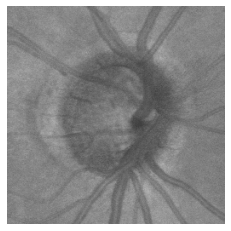

In [33]:
img_array = read_imgs_targz('data/tmp/OD.tar.gz')
show_volume(img_array)

<class 'matplotlib.image.AxesImage'>
60.0 90.0


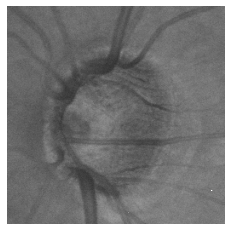

In [34]:

img_array = read_imgs_targz("/home/octusr2/projects/data_fast/proceeded/volume_targz/20210812-sysu-oct/ANGIO1/CRC-009-011/20180914/OS/OCT/3D disc/88949.fds.tgz")
show_volume(img_array)

In [19]:
print(img_array.norm.vmin, img_array.norm.vmax)

AttributeError: 'list' object has no attribute 'norm'

(256, 512)


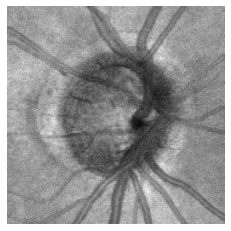

In [15]:
img_array = read_imgs_targz('data/tmp/OD.tar.gz')
show_volume(img_array)

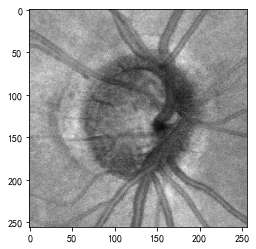

In [24]:
plt.imshow(res,cmap='gray')
plt.show()

# 使用yolo进行辅助定位切割部分

In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ZEGMp6xFiewvx0By7Oct")
project = rf.workspace().project("oct-7eipo")
dataset = project.version(2).download("yolov5")

  Using cached roboflow-0.2.1-py3-none-any.whl
  Using cached chardet-4.0.0-py2.py3-none-any.whl (178 kB)
  Using cached python_dotenv-0.19.2-py2.py3-none-any.whl (17 kB)
  Attempting uninstall: chardet
    Found existing installation: chardet 3.0.4
    Uninstalling chardet-3.0.4:
      Successfully uninstalled chardet-3.0.4


Duplicate key in file PosixPath('/home/octusr3/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 260 ('font.family:  sans-serif')
Duplicate key in file PosixPath('/home/octusr3/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 268 ('font.sans-serif: DejaVu Sans, Bitstream Vera Sans, Computer Modern Sans Serif, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif')
Duplicate key in file PosixPath('/home/octusr3/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 411 ('axes.unicode_minus: True  # use Unicode for the minus symbol rather than hyphen.  See')


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to OCT-2 in yolov5pytorch:: 100%|██████████| 484/484 [00:01<00:00, 417.62it/s]


以下部分是根据yolo定位的结果,重新切分新的视盘黄版图,前面通过yolov5进行了训练，可以定位视盘和黄斑的位置,不慎代码不小心删除,应该很快就可以补全训练及detect的过程。。。直接用yolov5官方detect出来的,后面黄斑改写一下
# 重新切割侧切图

In [18]:
tasks = get_all_volumes(cache=False)

In [15]:
import cv2 
import os
import matplotlib.pyplot as plt

def draw_box_in_single_image(image_path, txt_path):
    # 读取图像
    image = cv2.imread(image_path)

    # 读取txt文件信息
    def read_list(txt_path):
        pos = []
        with open(txt_path, 'r') as file_to_read:
            while True:
                lines = file_to_read.readline()  # 整行读取数据
                if not lines:
                    break
                    pass
                # 将整行数据分割处理，如果分割符是空格，括号里就不用传入参数，如果是逗号， 则传入‘，'字符。
                p_tmp = [float(i) for i in lines.split(' ')] 
                pos.append(p_tmp)  # 添加新读取的数据
                # Efield.append(E_tmp)
                pass
            
        return pos


    # txt转换为box
    def convert(size, box):
        
        xmin = (box[1]-box[3]/2.)*size[1]
        xmax = (box[1]+box[3]/2.)*size[1]
        ymin = (box[2]-box[4]/2.)*size[0]
        ymax = (box[2]+box[4]/2.)*size[0]
        box = (int(xmin), int(ymin), int(xmax), int(ymax))
        print(box)
        return box

    pos = read_list(txt_path)
    tl = int((image.shape[0]+image.shape[1])/2) +1
    lf = max(tl-1,1)
    for i in range(len(pos)):
        label = str(int(pos[i][0]))
        print('image_size is ', image.shape)
        box = convert(image.shape, pos[i])
        image = cv2.rectangle(image,(box[0], box[1]),(box[2],box[3]),(0,255,0),1)
        cv2.putText(image,label,(box[0],box[1]-2), 0, tl, [255,255,255], thickness=1, lineType=cv2.LINE_AA)
        pass
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 
    plt.show()
    # cv2.imshow("images", image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()


Duplicate key in file PosixPath('/home/octusr3/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 260 ('font.family:  sans-serif')
Duplicate key in file PosixPath('/home/octusr3/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 268 ('font.sans-serif: DejaVu Sans, Bitstream Vera Sans, Computer Modern Sans Serif, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif')
Duplicate key in file PosixPath('/home/octusr3/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 411 ('axes.unicode_minus: True  # use Unicode for the minus symbol rather than hyphen.  See')


In [16]:
file_path='/home/octusr3/project/data_fast/z_slice/20210820-sysu-oct/MAGIC3/MAGIC1631/20210525/OS/OCT/3D disc/111931.fds.jpg'
label_path='/home/octusr3/project/data_fast/z_slice/20210820-sysu-oct/MAGIC3/MAGIC1631/20210525/OS/OCT/3D disc/111931.fds.txt'
# 0 是 disc 视盘 1 是黄斑

image_size is  (217, 217, 3)
(88, 57, 174, 133)


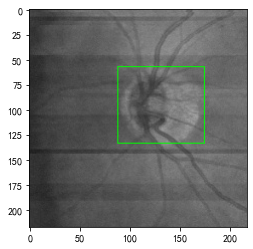

In [17]:
draw_box_in_single_image(file_path, label_path)

In [2]:
from pathlib import Path
original_data_path = '/home/octusr3/project/oct_wk/data.csv'
z_slice_path=Path('/home/octusr3/project/data_fast/z_slice')

In [9]:
import pandas as pd
data=pd.read_csv(original_data_path)
data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [13]:
def get_center_point(txt_path):
    pos = []
    with open(str(txt_path), 'r') as file_to_read:
        while True:
            lines = file_to_read.readline()  # 整行读取数据
            if not lines:
                break
                pass
            # 将整行数据分割处理，如果分割符是空格，括号里就不用传入参数，如果是逗号， 则传入‘，'字符。
            p_tmp = [float(i) for i in lines.split(' ')] 
            pos.append(p_tmp)  # 添加新读取的数据
            # Efield.append(E_tmp)
            pass
    pos=pos[0]
    #print(pos)
    print(pos[2]*256)
    return (int(pos[1]*256),int(pos[2]*256))


In [14]:
label_path='/home/octusr3/project/data_fast/z_slice/20210820-sysu-oct/MAGIC3/MAGIC1631/20210525/OS/OCT/3D disc/111931.fds.txt'
res=get_center_point(label_path)

113.253376


In [11]:
def calculate_all_center(label_path):
    #center_point=[]
    
    if label_path.exists():
        print(label_path)
        return get_center_point(label_path)
    else:
        return (255//2,255//2)

In [12]:
def get_center(data):
    z_slice_path=Path('/home/octusr3/project/data_fast/z_slice')
    label_path=(z_slice_path/data['image_path']).with_suffix('.txt')
    temp=calculate_all_center(label_path)
    return temp

In [13]:
data['center_point']=data.apply(get_center, axis=1)

/home/octusr3/project/data_fast/z_slice/20210730-中山眼科-OCT转VF/CASIA数据汇总-new/CS-199/20190612/OD/OCT-后/3D Disc/1055.fds.txt
/home/octusr3/project/data_fast/z_slice/20210730-中山眼科-OCT转VF/CASIA数据汇总-new/CS-199/20190612/OS/OCT-后/3D Disc/1058.fds.txt
/home/octusr3/project/data_fast/z_slice/20210730-中山眼科-OCT转VF/CASIA数据汇总-new/CS-201/20190613/OD/OCT-后/3D Disc/1112.fds.txt
/home/octusr3/project/data_fast/z_slice/20210730-中山眼科-OCT转VF/CASIA数据汇总-new/CS-201/20190613/OS/OCT-后/3D Disc/1114.fds.txt
/home/octusr3/project/data_fast/z_slice/20210730-中山眼科-OCT转VF/CASIA数据汇总-new/CS-204/20190613/OD/OCT-后/3D Disc/1179.fds.txt
/home/octusr3/project/data_fast/z_slice/20210730-中山眼科-OCT转VF/CASIA数据汇总-new/CS-204/20190613/OS/OCT-后/3D Disc/1181.fds.txt
/home/octusr3/project/data_fast/z_slice/20210730-中山眼科-OCT转VF/CASIA数据汇总-new/CS-205/20190613/OD/OCT-后/3D Disc/1206.fds.txt
/home/octusr3/project/data_fast/z_slice/20210730-中山眼科-OCT转VF/CASIA数据汇总-new/CS-205/20190613/OD/OCT-后/3D Disc/1206.fds.txt
/home/octusr3/project/data_fast/

In [1]:
import pandas as pd
data=pd.read_csv('data.csv')

/home/octusr3/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
targz=[]
from pathlib import Path
for i in data['image_path']:
    #print(i)
    tar_gz_path=Path('/home/octusr2/projects/data_fast/proceeded/volume_targz')
    label_path=(tar_gz_path/i).with_suffix('.tgz')
    #print(label_path)
    targz.append(label_path)

In [3]:
from Utils import *
def cut_cp_from_imgs_bupt(img_array, center_x,center_y,volume_size, flip=False, radius=1, threshold=100, size=(380, 380)):
    volume = np.stack(img_array, axis=0)
    volume = volume.transpose(0,2,1)
    volume = volume[:, ::2, :]
    
    if flip:
        volume = np.flip(volume, axis=1)
    y, x = np.mgrid[255:-1:-1, 0:256:1]
    
    dis = (x - center_x) ** 2 + (y - center_y) ** 2
    valid_mask = np.abs(dis - (radius / volume_size * 256) ** 2) < threshold
    theta = np.arctan2(y - center_y, x - center_x)
    #这里好像出现了问题，需要重新切数据
    masked_theta = theta[valid_mask]
    masked_volume = volume[valid_mask, :]
    img = masked_volume[masked_theta.argsort()]
    img = cv2.resize(img, dsize=size, interpolation=cv2.INTER_LINEAR)
    return img.transpose()
    
def chunk(list, n):
    result = []
    for i in range(n):
        result.append(list[math.floor(i / n * len(list)):math.floor((i + 1) / n * len(list))])
    return result

def run_multi_process(item_list, n_proc, func, with_proc_num=False):
    tasks = chunk(item_list, n_proc)
    if with_proc_num:
        for i in range(len(tasks)):
            tasks[i] = (i, tasks[i])
    with multiprocessing.Pool(processes=n_proc) as pool:
        results = pool.map(func, tasks)
    return results

def extract_cp_mp_bupt(tasks, size):
    input_root = Path('/home/octusr2/projects/data_fast/proceeded/volume_targz')
    output_root = Path(f'/home/octusr3/project/data_fast/new_slice')
    info = pd.read_csv('/home/octusr2/projects/data_fast/proceeded/volume_info/volume_info.csv')
    info['oct_path'] = info['oct_path'].map(lambda x: str(Path(x).with_suffix('')))
    info = info.drop_duplicates(subset='oct_path')
    info = info.set_index('oct_path')
    errors = run_multi_process(tasks, 60, partial(extract_cp_bupt, input_root=input_root, output_root=output_root, info=info, size=size), with_proc_num=True)
    errors = reduce(lambda x, y: x + y, errors)
    pkl_dump(errors, 'data/errors_cp.pkl')

def extract_cp_bupt(tasks, input_root, output_root, info, size):
    info = info.copy()
    data=pd.read_csv('/home/octusr3/project/oct_wk/data.csv')
    proc_num, tasks = tasks
    errors = []
    with Benchmark(f'Converting', print=proc_num == 0) as t:
        for i, task in enumerate(tasks):
            if i % (len(tasks) // 10 + 1) == 0:
                t.print_elapsed(f'{i}/{len(tasks)}, {i / len(tasks) * 100:.2f}%')
            task = Path(task).relative_to(input_root)
            info_key = str(task.with_suffix('').with_suffix(''))
            
            if info_key not in info.index:
                err = Exception('No oct info.')
                errors.append((task, err))
                # print(f'Error with file {str(task)}: {err}')
                continue
            volume_size = info.loc[info_key, 'oct_x']
            input_path = str(input_root / task)
            output_path = (output_root / task).with_suffix('.jpg')
            #print(3)
            key_path=task.with_suffix('.jpg')
            print(key_path)
           # print(data.loc[data['image_path']==key_path])['center_point'].values[0]
            a=data[data['image_path']==str(key_path)]['center_point'].values[0]
            center_x,center_y=[int(x) for x in a.strip('(').strip(')').split(',')]
            #print(center_x,center_y)
            eye = ''
            if 'OD' in input_path:
                eye = 'OD'
            else:
                eye = 'OS'
            if eye == '':
                err = Exception('No eye infomation (OS/OD)')
                errors.append((task, err))
                # print(f'Error with file {str(task)}: {err}')
                continue
            try:
                imgs = read_imgs_targz(input_path)

                cp = cut_cp_from_imgs_bupt(imgs, center_x,center_y,volume_size=volume_size, flip=eye=='OS', radius=1.4, threshold=100, size=(size, size))
                ensure_file(output_path)
                Image.fromarray(cp).save(output_path)
            except Exception as err:
                errors.append((task, err))
                # print(f'Error with file {str(task)}: {err}')
    return errors

Duplicate key in file PosixPath('/home/octusr3/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 260 ('font.family:  sans-serif')
Duplicate key in file PosixPath('/home/octusr3/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 268 ('font.sans-serif: DejaVu Sans, Bitstream Vera Sans, Computer Modern Sans Serif, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif')
Duplicate key in file PosixPath('/home/octusr3/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 411 ('axes.unicode_minus: True  # use Unicode for the minus symbol rather than hyphen.  See')


In [4]:
extract_cp_mp_bupt(targz, size=512)


Converting: begin
Converting, 0/223, 0.00%: 0.05 seconds
20210730-中山眼科-OCT转VF/CASIA数据汇总-new/CS-199/20190612/OD/OCT-后/3D Disc/1055.fds.jpg
20210730-中山眼科-OCT转VF/MAGIC-数据汇总/MAGIC1045/20201209/OS/OCT/3D disc/90493.fds.jpg
20210730-中山眼科-OCT转VF/CASIA数据汇总-new/CS-199/20190612/OS/OCT-后/3D Disc/1058.fds.jpg
20210730-中山眼科-OCT转VF/MAGIC-数据汇总/MAGIC1061/20190505/OD/OCT/3D Disc/101881.fds.jpg
20210730-中山眼科-OCT转VF/CASIA数据汇总-new/CS-201/20190613/OD/OCT-后/3D Disc/1112.fds.jpg
20210730-中山眼科-OCT转VF/MAGIC-数据汇总/MAGIC1061/20190505/OS/OCT/3D Disc/101890.fds.jpg20210730-中山眼科-OCT转VF/CASIA数据汇总-new/CS-201/20190613/OS/OCT-后/3D Disc/1114.fds.jpg

20210730-中山眼科-OCT转VF/IG/CRC000020/IG010357/OD/20191126/OCT/3D disc/26899.fds.jpg20210730-中山眼科-OCT转VF/MAGIC-数据汇总/MAGIC1061/20200713/OD/OCT/3D disc/62563.fds.jpg20210730-中山眼科-OCT转VF/CASIA数据汇总-new/CS-204/20190613/OD/OCT-后/3D Disc/1179.fds.jpg


20210812-sysu-oct/ANGIO2/CRC-016-023/20190829/OS/OCT/3D disc/108610.fds.jpg
20210730-中山眼科-OCT转VF/CASIA数据汇总-new/CS-204/20190613/OS/OCT-后

In [234]:
data=pd.read_csv('/home/octusr3/project/oct_wk/data.csv')

In [235]:
data

,Unnamed: 0,image_path,source,pid,dates,eye,pos,num,pd_prob,dataset,pred,center_point
0,0,20210730-中山眼科-OCT转VF/CASIA数据汇总-new/CS-199/2019...,CASIA数据汇总-new,CS-199,2019-06-12,OD,disc,[[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]\n [...,[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]\n [0. 0. 0. 1...,0,[22.05466 25.032394 25.439856 25.083515 22.054...,"(117, 122)"
1,1,20210730-中山眼科-OCT转VF/CASIA数据汇总-new/CS-199/2019...,CASIA数据汇总-new,CS-199,2019-06-12,OS,disc,[[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]\n [...,[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]\n [0. 0. 0. 1...,0,[24.283096 25.065544 25.896633 23.330849 24.28...,"(126, 122)"
2,2,20210730-中山眼科-OCT转VF/CASIA数据汇总-new/CS-201/2019...,CASIA数据汇总-new,CS-201,2019-06-13,OD,disc,[[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]\n [...,[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]\n [0. 0. 0. 3...,0,[23.915213 21.33554 20.794312 21.558468 23.915...,"(125, 123)"
3,3,20210730-中山眼科-OCT转VF/CASIA数据汇总-new/CS-201/2019...,CASIA数据汇总-new,CS-201,2019-06-13,OS,disc,[[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]\n [...,[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]\n [0. 0. 0. 1...,0,[25.973618 20.867485 21.725033 25.36363 25.973...,"(232, 228)"
4,4,20210730-中山眼科-OCT转VF/CASIA数据汇总-new/CS-204/2019...,CASIA数据汇总-new,CS-204,2019-06-13,OD,disc,[[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]\n [...,[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]\n [0. 0. 0. 1...,0,[27.698353 25.101007 25.110176 25.102798 27.69...,"(124, 117)"
...,...,...,...,...,...,...,...,...,...,...,...,...
13387,13387,20210820-sysu-oct/MAGIC4/MAGIC2238/20210628/OS...,MAGIC4,MAGIC2238,2021-06-28,OS,disc,[[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]\n [...,[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]\n [0. 0. 0. 1...,4,[26.975718 29.492573 29.29149 27.73583 26.9757...,"(140, 113)"
13388,13388,20210820-sysu-oct/MAGIC4/MAGIC2242/20210713/OD...,MAGIC4,MAGIC2242,2021-07-13,OD,disc,[[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]\n [...,[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]\n [0. 0. 0. 4...,4,[29.29377 26.508043 26.74595 26.635784 29.2937...,"(103, 122)"
13389,13389,20210820-sysu-oct/MAGIC4/MAGIC2242/20210713/OD...,MAGIC4,MAGIC2242,2021-07-13,OD,disc,[[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]\n [...,[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]\n [0. 0. 0. 4...,4,[29.939627 29.491547 29.325294 29.26425 29.939...,"(104, 122)"
13390,13390,20210820-sysu-oct/MAGIC4/MAGIC2242/20210713/OS...,MAGIC4,MAGIC2242,2021-07-13,OS,disc,[[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]\n [...,[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]\n [0. 0. 0. 3...,4,[29.924528 29.396008 29.238306 29.68228 29.924...,"(151, 129)"


In [218]:
a=data.loc[data['image_path']=='20210730-中山眼科-OCT转VF/CASIA数据汇总-new/CS-204/20190613/OD/OCT-后/3D Disc/1179.fds.jpg','center_point'].values

In [225]:
bupt=data.loc[data['image_path']=='20210730-中山眼科-OCT转VF/CASIA数据汇总-new/CS-204/20190613/OD/OCT-后/3D Disc/1179.fds.jpg']['center_point']

In [229]:
bupt.values[0][1]

117

In [219]:
c,d=a[0]

In [220]:
c

124